# Final notebook of the neighborhood pricing Kaggle contest

In [1]:
# Import my tools
import numpy as np
import pandas as pd
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
df = pd.read_csv('clean.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
#df.fillna(0, inplace=True)
df = df.convert_dtypes()

In [3]:
# a quick thing to only display the missing entries
def Missing (train):
    Missing={n:train[n].isna() for n in train.keys()}
    Missing_data=pd.DataFrame(Missing).sum()
    results=Missing_data[Missing_data>0]
    return results

In [4]:
Missing(df)

LotFrontage      257
Alley           1361
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      686
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1445
Fence           1171
MiscFeature     1399
dtype: int64

In [ ]:
categorical_columns = df.select_dtypes(['string','object']).columns
numerical_columns = df.select_dtypes(['Int64','float64']).columns

X=df.drop('SalePrice',axis=1)
y=df[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

In [ ]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = rf.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [108]:
Missing(df)

LotFrontage      257
Alley           1361
BsmtQual          37
BsmtCond          37
BsmtExposure      38
                ... 
GarageQual        81
GarageCond        81
PoolQC          1445
Fence           1171
MiscFeature     1399
Length: 16, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')


In [6]:
Missing(df2)

Series([], dtype: int64)

In [7]:
X2=df2.drop('SalePrice',axis=1)
y2=df2[['SalePrice']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=7) # random_state used for reproducibility
print(X2_train.shape, X2_test.shape)
print(y2_train.shape,y2_test.shape)

(1089, 81) (363, 81)
(1089, 1) (363, 1)


Score:  0.9370257481598844


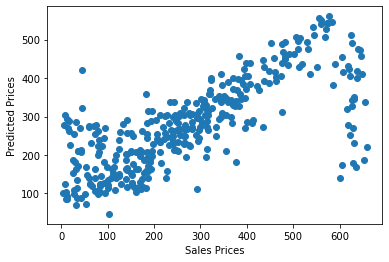

In [8]:
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model_res = clf.fit(X2_train, y2_train)
y_pred = model_res.predict(X2_test)
score = model_res.score(X2_train,y2_train)
plt.scatter(y2_test,y_pred)
plt.xlabel('Sales Prices')
plt.ylabel('Predicted Prices')
print('Score: ',score)

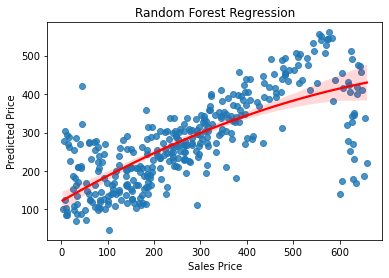

In [9]:
rf_plot=sns.regplot(y2_test,y_pred,line_kws={"color": "red"}, order=2)
rf_plot=plt.title('Random Forest Regression')
rf_plot=plt.xlabel('Sales Price')
rf_plot=plt.ylabel('Predicted Price')
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df3=df.copy()
# Dropping Columns with nan for the Dummy Variable list
nan_values = df3.isna()
nan_columns = nan_values.any()
columns_with_nan = df3.columns[nan_columns].tolist()
print('Columns with NaN',columns_with_nan)
pd.set_option('display.max_rows', 10)
df3=df3.drop(columns_with_nan, axis=1)
print('Columns kept',df3.columns)

cat_columns = df3.select_dtypes(['string']).columns
for n in cat_columns:
    le.fit(df3[n])
    df3[n]=le.transform(df3[n])

Columns with NaN ['LotFrontage', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Columns kept Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'G

In [19]:
X=df3.drop('SalePrice',axis=1)
y=df3[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=7) # random_state used for reproducibility
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(1089, 65) (363, 65)
(1089, 1) (363, 1)


Score:  0.9828522161402601


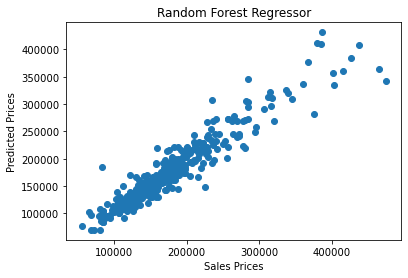

In [30]:
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
score = model_res.score(X_train,y_train)
plt.scatter(y_test,y_pred)
plt.title('Random Forest Regressor')
plt.xlabel('Sales Prices')
plt.ylabel('Predicted Prices')
print('Score: ',score)

In [31]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
scores = cross_val_score(clf, X_test, y_test, cv=5)
scores

array([0.88129311, 0.83356839, 0.88756997, 0.84971262, 0.78497162])